# 📘 MobileNetV3 - FER2013 - Train and Evaluation

Notebook này trình bày cách huấn luyện và đánh giá mô hình **MobileNetV3** trên tập dữ liệu cảm xúc khuôn mặt **FER2013**.

Nội dung gồm:
1.	Tải và tiền xử lý dữ liệu
2.	Định nghĩa mô hình (MobileNetV3)
3.	Huấn luyện mô hình
4.	Đánh giá: Độ chính xác (Accuracy), Ma trận nhầm lẫn (Confusion Matrix), Thời gian suy luận (Inference Time), Kích thước mô hình (Model Size)

Cấu trúc thư mục dữ liệu phải được tổ chức thành hai thư mục train/ và test/, mỗi thư mục chứa các thư mục con tương ứng với từng nhãn cảm xúc.

In [2]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

## 📂 1. Load and Preprocess Data
We use `ImageDataGenerator` to load images from folders.

In [43]:
# 🔧 Cấu hình
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7

train_path = 'data/train'
test_path = 'data/test'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
# 📊 Dữ liệu test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 🧠 2. Define MobileNetV3 Model
We use the pretrained MobileNetV3 (small variant) as base.

In [49]:
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# 🔓 Fine-tune 30 layer cuối
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
    
# 🏗️ Xây dựng model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# ⚙️ Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



## 🏋️‍♂️ 3. Train the Model
We train for a few epochs with validation data.

In [20]:
# 📈 Huấn luyện model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


C:\Users\lam46\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 609s 838ms/step - accuracy: 0.2257 - loss: 1.8693 - val_accuracy: 0.1427 - val_loss: 1.9292
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 392s 547ms/step - accuracy: 0.2403 - loss: 1.8061 - val_accuracy: 0.1427 - val_loss: 1.8787
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 396s 551ms/step - accuracy: 0.2728 - loss: 1.7722 - val_accuracy: 0.2513 - val_loss: 1.8829
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 652s 909ms/step - accuracy: 0.2880 - loss: 1.7513 - val_accuracy: 0.2513 - val_loss: 2.0020
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 386s 538ms/step - accuracy: 0.3104 - loss: 1.7192 - val_accuracy: 0.2646 - val_loss: 1.8753
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 356s 495ms/step - accuracy: 0.3158 - loss: 1.7096 - val_accuracy: 0.2679 - val_loss: 1.8381
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 333s 465ms/step - accuracy: 0.3284 - loss: 1.6877 - val_accuracy: 0.2916 - val_loss: 1.7557
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 329s 459ms/step - accuracy: 0.3355 -

## 📊 4. Evaluation
We evaluate with accuracy, confusion matrix, inference time, and model size.

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - accuracy: 0.2234 - loss: 1.7921 
Test Accuracy: 31.29%
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 116s 16ms/step


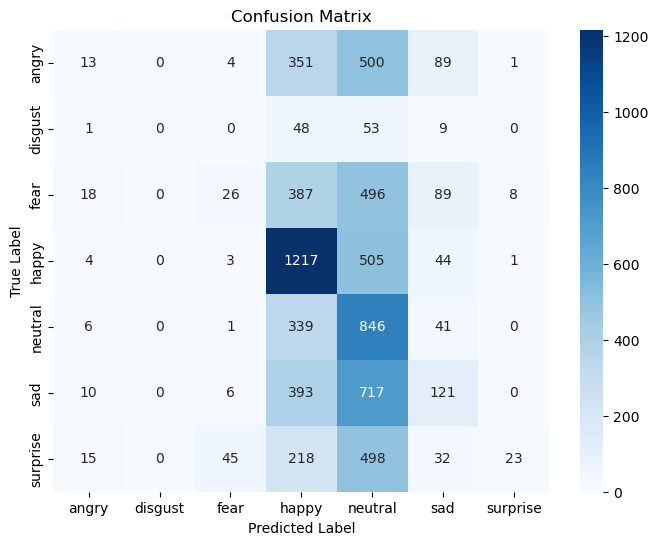

In [24]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(test_generator.filenames) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step 
Average Inference Time: 10.41 ms/image


In [29]:
# Model Size
model.save("mobilenetv3_fer2013.h5")
size_mb = os.path.getsize("mobilenetv3_fer2013.h5") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.37 MB
